# Required Library

In [17]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image

# Prepare Dataset

In [12]:
# Paths
DATA_DIR    = r'C:\Users\ASUS ZENBOOK\Desktop\Dataset'
TRAIN_DIR   = os.path.join(DATA_DIR, 'Train')
VAL_DIR     = os.path.join(DATA_DIR, 'Valid')
TEST_DIR    = os.path.join(DATA_DIR, 'Test')

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Automatically detect the number of classes
class_names = os.listdir(TRAIN_DIR)  # Assuming classes are in the train directory
num_classes = len(class_names)

# Print detected classes vertically
print(f"Detected {num_classes} classes:")
for class_name in class_names:
    print(f"- {class_name}")

# Define the preprocess_image function
def preprocess_image(image):
    # Ensure the image is in the correct format
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)
    
    # Convert numpy array to PIL Image
    image = Image.fromarray(image)
    
    if image.mode == 'P':  # If the image is in palette mode
        image = image.convert('RGBA')
    
    # Convert back to numpy array and ensure it's in float32 format
    return np.array(image).astype(np.float32)

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_image
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=preprocess_image
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=preprocess_image
)

# Load datasets
train_data = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save class indices
with open("class_indices.json", "w") as f:
    json.dump(train_data.class_indices, f)

# Ensure test data uses the same class indices
test_data.class_indices = train_data.class_indices

Detected 10 classes:
- Baked Potato
- Burger
- Crispy Chicken
- Donut
- Fries
- Hot Dog
- Pizza
- Sandwich
- Taco
- Taquito
Found 15000 images belonging to 10 classes.
Found 3500 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


#  Build & Train Model

In [14]:
# Define the build_model function
def build_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # Unfreeze the base model layers for fine-tuning

    # Fine-tune some layers
    for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
        layer.trainable = False

    # Add custom layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Custom callback to log learning rate
class LearningRateLogger(Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        self.learning_rates.append(lr)
        logs = logs or {}
        logs['learning_rate'] = lr

# Build model
model = build_model(num_classes=num_classes)

# Compile the model with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Initialize the logger
lr_logger = LearningRateLogger()

# Callbacks
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
    restore_best_weights=True
)

# Train the model with reduced epochs
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  # Reduced number of epochs
    callbacks=[checkpoint, early_stopping, lr_logger]  # Added early stopping
)

# Save the model
model.save('final_model.h5')

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1028s 2s/step - accuracy: 0.1390 - loss: 2.3014 - val_accuracy: 0.1554 - val_loss: 2.3585 - learning_rate: 1.0000e-04
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - accuracy: 0.1789 - loss: 2.2035 - val_accuracy: 0.1460 - val_loss: 2.6398 - learning_rate: 1.0000e-04
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 550s 1s/step - accuracy: 0.1943 - loss: 2.1623 - val_accuracy: 0.1511 - val_loss: 2.8557 - learning_rate: 1.0000e-04
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 433s 919ms/step - accuracy: 0.1987 - loss: 2.1605 - val_accuracy: 0.1680 - val_loss: 2.7160 - learning_rate: 1.0000e-04
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 590s 1s/step - accuracy: 0.2086 - loss: 2.1300 - val_accuracy: 0.1666 - val_loss: 2.8227 - learning_rate: 1.0000e-04
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 576s 1s/step - accuracy: 0.2232 - loss: 2.1147 - val_accuracy: 0.1831 - val_loss: 2.7584 - learning_rate: 1.0000e-04


# Plotting

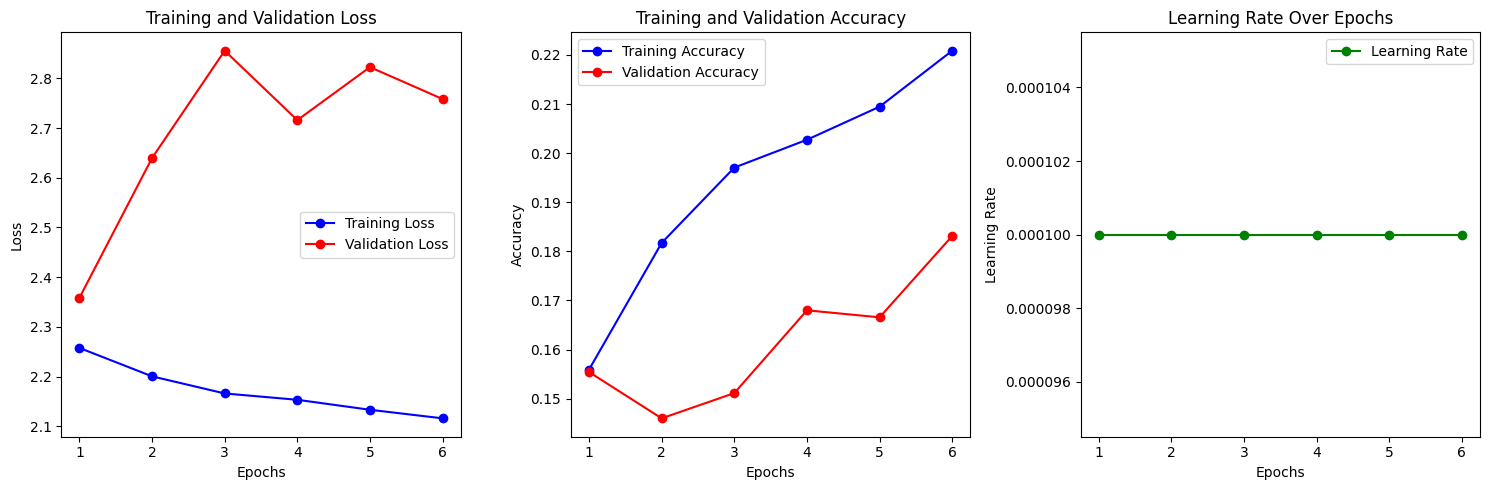

In [15]:
epochs = range(1, len(lr_logger.learning_rates) + 1)

# Loss Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'][:len(epochs)], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'][:len(epochs)], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['accuracy'][:len(epochs)], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'][:len(epochs)], 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Learning Rate Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, lr_logger.learning_rates, 'go-', label='Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Model

Accuracy

In [20]:
import tensorflow as tf
from tensorflow.keras.models import load_model  # Import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model("best_model.keras")  # Ensure the model path is correct

# Set up the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]

# Create a test data generator from the directory
test_generator = test_datagen.flow_from_directory(
    r'C:\Users\ASUS ZENBOOK\Desktop\Dataset\Test',  # Path to your test data
    target_size=(224, 224),  # Resize images to match the model's input size
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False  # Important for evaluation to maintain the order of predictions
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 1500 images belonging to 10 classes.
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 337ms/step - accuracy: 0.8557 - loss: 0.4699
Test Accuracy: 79.60%


In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model  # Import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the trained model
model = load_model("final_model.h5")  # Ensure the model path is correct

# Set up the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values to [0, 1]

# Create a test data generator from the directory
test_generator = test_datagen.flow_from_directory(
    r'C:\Users\ASUS ZENBOOK\Desktop\Dataset\Test',  # Path to your test data
    target_size=(224, 224),  # Resize images to match the model's input size
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False  # Important for evaluation to maintain the order of predictions
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 1500 images belonging to 10 classes.


c:\Users\ASUS ZENBOOK\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 352ms/step - accuracy: 0.8557 - loss: 0.4699
Test Accuracy: 79.60%


In [34]:
test_loss,test_accuracy = model.evaluate(test_generator,batch_size = 32, verbose = 0)
print('\nThe accuracy of the model for test data is:',test_accuracy*100)
print('The Loss of the model for test data is:',test_loss)


The accuracy of the model for test data is: 79.60000038146973
The Loss of the model for test data is: 0.6468400359153748


Confusion Matrix

In [39]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step


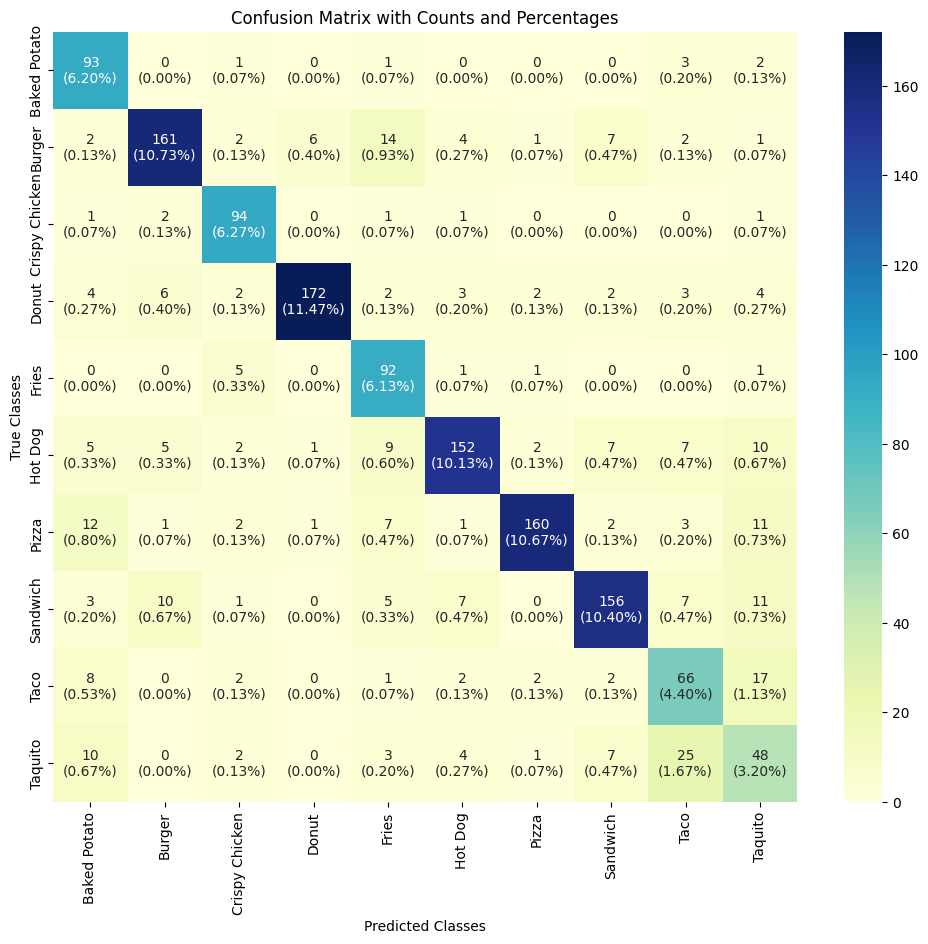

In [49]:
labels = test_generator.class_indices
class_names = {v: k for k, v in labels.items()}  # Invert the dictionary to map indices to class names

# Compute confusion matrix
cf_mtx = confusion_matrix(y_true, y_pred)

# Generate counts and percentages
group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cf_mtx, xticklabels=class_names.values(), yticklabels=class_names.values(),
            cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix with Counts and Percentages')
plt.show()

Classification Report


In [51]:
print(classification_report(y_true, y_pred, target_names=class_names.values()))

                precision    recall  f1-score   support

  Baked Potato       0.67      0.93      0.78       100
        Burger       0.87      0.81      0.84       200
Crispy Chicken       0.83      0.94      0.88       100
         Donut       0.96      0.86      0.91       200
         Fries       0.68      0.92      0.78       100
       Hot Dog       0.87      0.76      0.81       200
         Pizza       0.95      0.80      0.87       200
      Sandwich       0.85      0.78      0.81       200
          Taco       0.57      0.66      0.61       100
       Taquito       0.45      0.48      0.47       100

      accuracy                           0.80      1500
     macro avg       0.77      0.79      0.78      1500
  weighted avg       0.81      0.80      0.80      1500



# Saved Model

In [52]:
# Create the directory if it doesn't exist
os.makedirs('saved_model', exist_ok=True)

# Load the trained model
model = load_model("best_model.keras")  # Use the final model for saving

# Save the model in the SavedModel format
model.save('saved_model/FIT.keras')